# ASP3231 Laboratory 3: Shift, Scale and Combine images

In this week's laboratory we are going to shift, scale and combine images. Doing this is critical to produce combined images where the signal-to-noise is improved, poor quality data is rejected and object fluxes (measured in ADU) that can then be tied to calibrated magnitudes. 

## Prelab Questions

You are expected to read the lab notebook prior to the lab, and the Prelab Questions are designed to prompt you to consider what you have read. This will hopefully prepare you for the lab session and ultimately save time.

#### Question 1: Why do we subtract the background before combining images?

#### Question 2: Why is it often better to take 10 exposures of a science object and combine them instead of taking a single longer exposure?

#### Question 3: What is an advantage of a median combine over a mean combine?

#### Question 4: The traditional centroid is a flux weighted mean of the x-y pixels positions. Using online resources, find out what the astropy centroid_2dg function.

#### Question 5: Why is it important to visually inspect images with ds9? What sort of errors could visual inspection catch that may be missed by statistics calculated automatically? 

#### Quation 6: We will be using for loops quite often in this notebook.  Write a Python program to construct the following pattern, using a loop and just a single print statement:
p <br>
py <br>
pyt <br>
pyth <br>
pytho <br>
python <br>



>Q1 - Because we have a reference for our background only valid for single science images, not combined science images.

>Q2 - Because it's easier to take 10 separate exposures - the observation is less prone to disturbances like knocking/human error. If a 10 minute exposure is ruined, that's 10 minutes wasted and we need to take another 10 minute exposure. But if one of the 1 minute exposures is ruined throughout the course of taking 10 1 minute exposures, we can discard that exposure, waste 1 minute, and take another exposure.

>This also transfers over to analysis after the fact - if you get back to the lab and discover that one of your 10 minute exposures has been ruined somehow, you can't discard 3 minutes' worth of that exposure and continue to analyse the data. If you have separate 1 minute exposures, you can still perform analysis.

>Similarly, it ensures that all your data isn't ruined by anomalous events - like in Q3.

>Q3 - A median combine is less prone to outliers. For example, in outside of visual wavelength observations, a streak of few pixels can be completely saturated by a cosmic ray of some sort. A median combine will discard the outlier pixels if those appear only in one exposure, whereas a mean will factor those in to produce a skewed combine.

>At a less extreme scale, this logic also applies for pixels that have been disproportionately saturated by Gaussian noise purely as a result of probability.

>Q4 - Calculate the centroid of a 2D array by fitting a 2D Gaussian (plus a constant) to the array - per the photutils documentation.

>Q5 - Some large-scale qualitative human error like a telescope being knocked generating a junk image, or perhaps more subtly and likely - something like a dark exposure being marked as a science exposure due to a mistake in naming conventions or metadata assignment.


In [94]:
# Q6 - just for a bit of fun!
# I've used some more functional Python syntax here - range(len(py_string)) is an iterable that contains (0, 1, ..., length of the string "python" - 1)
# or in other words the indices of the string with which we can slice.
# I've then defined an anonymous (lambda) function that takes ONE of these indices and prints the corresponding substring.
# Finally, I've mapped that function over the iterable of indices, which effectively feeds those indices as successive inputs into the anonymous function, causing the printing.
# However, map only returns an iterable, and the elements aren't executed until they are 'read'. Therefore, I need to execute all the print commands in the resulting iterable with
# something like a list cast, which intrinscally needs to access all the elements of an iterable.

py_string = "python"

list(map(lambda i: print(py_string[:i+1]), range(len(py_string))));




p
py
pyt
pyth
pytho
python


## End of Pre-Lab

# Lab 3. Shift, Scale and Combine images

### By the end of this lab, you should be able to:
- shift images **correctly**
- scale images and understand why you need to scale images
- understand several different methods used for combining images
- provide a combined image with improved signal-to-noise relative to the indiviudal exposures

### Let's begin

**Task 1.** Import all the needed libraries. Can you identify a library or function we didn't use in the previous lab?  

In [95]:
# Import various libraries and some specific functions. Note the additions relative to the previous lab.

import numpy as np
import astropy
import ccdproc
from ccdproc import CCDData, Combiner
from astropy import units as u
from astropy.visualization import SqrtStretch
import matplotlib.pyplot as plt 
from matplotlib.colors import LogNorm
from photutils import centroid_com, centroid_1dg, centroid_2dg
from photutils import CircularAperture
from photutils import aperture_photometry
from photutils import Background2D
from photutils import MedianBackground
from scipy.ndimage import shift
import gc                                                           
gc.enable()

/var/folders/96/7k6ct_j920xfpsdx5s87gnjr0000gn/T/ipykernel_75053/3911332741.py:11: DeprecationWarning: `photutils.centroid_com` is a deprecated alias for `photutils.centroids.centroid_com`. Instead, please use `from photutils.centroids import centroid_com` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
/var/folders/96/7k6ct_j920xfpsdx5s87gnjr0000gn/T/ipykernel_75053/3911332741.py:11: DeprecationWarning: `photutils.centroid_1dg` is a deprecated alias for `photutils.centroids.centroid_1dg`. Instead, please use `from photutils.centroids import centroid_1dg` to silence this warning.
  from photutils import centroid_com, centroid_1dg, centroid_2dg
/var/folders/96/7k6ct_j920xfpsdx5s87gnjr0000gn/T/ipykernel_75053/3911332741.py:11: DeprecationWarning: `photutils.centroid_2dg` is a deprecated alias for `photutils.centroids.centroid_2dg`. Instead, please use `from photutils.centroids import centroid_2dg` to silence this warning.
  from photutils import 

>We didn't use scipy in the last lab! It's a library that provides optimised implementation for many commonly used algorithms in scientific computing.

**Task 2.** Our starting point is processed V-band images of NGC 2362 that have an exposure time of 30 seconds. Display one of these images using the ds9, and modify the scale using the minmax and zscale options. 

Display that same image in this notebook and use the *vmin and vmax* parameters of function *imshow* to mimic the colour scale of ds9. Use the links below for more help:

https://matplotlib.org/api/_as_gen/matplotlib.pyplot.imshow.html

https://docs.astropy.org/en/stable/visualization/normalization.html



>I displayed the image using ds9 - I see some sort of cluster of stars, possibly an open cluster. There is one bright star in the centre of the image, then a scattering of stars of lesser brightness all congregated towards the centre of image.

>The linear scale in ds9 produces the best image compared to the log scale - selecting a log scale produces an image that is washed out and lacking in contrast. This is probably because of a large variation in photon count across the image.

>Z scale in ds9 has produced what appears to be a linear scale with a lower bound of around 1.2 * 10^2 counts and an upper bound of around 4.5 * 10^2 counts, so I set that as my vmin and vmax in the operation below.

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


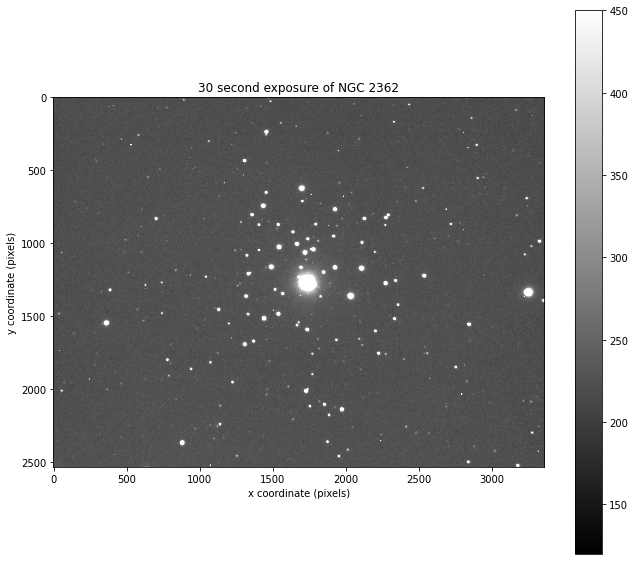

In [96]:
image_00009656 = CCDData.read("proc_NGC_2362_V_30.000secs00009656.fits", unit="adu")
fig, ax = plt.subplots(figsize = (11,10))
plt.imshow(image_00009656, cmap='gray', vmin=1.2*100, vmax=4.5*100)
plt.xlabel('x coordinate (pixels)')
plt.ylabel('y coordinate (pixels)')
plt.title('30 second exposure of NGC 2362')
plt.colorbar()


<font color='Blue'> **Figure 1**: 30 second exposure of NGC 2362 with linear colour scale.

>An interesting difference between the python displayed image and the ds9 image is that the 'resolution' of the plot of python appears to be lower. The effect this has is that the noise is a lot more visible in ds9 than in Figure 1 (where the area outside the stars blends into a more uniform grey), but the same colour scale ensures that contiguous highly illuminated regions like stars are displayed similarly. This is probably due to difference in algorithmic downscaling.

>Ie, for equal colour scale, the same stars are distinct to the eye as the .fits file opened in ds9.

>There also seems to be some other effect going on here - as you zoom OUT of the image in ds9, there seems to be some sort of algorithm in use that (given that the display resolution is now lower than the source resolution) determines the level of illumination of the pixel to be displayed on the user's screen. This is more natural in ds9 and retains the 'nature' of the noise more than python.

**Task 3.** Let's create a collection of processed V-band images of NGC 2362 (called images).

In [97]:
images = ccdproc.ImageFileCollection(".",glob_include='proc_NGC_2362_V_30*')

**Task 4.** Let's now read these images into scim, using code adapted from the previous lab. (Note the use of PICTTYPE is somewhat redundant in this particular instance, but would catch misnamed images.)

In [98]:
scim = [CCDData.read(fn, unit = "adu") for fn in images.files_filtered(PICTTYPE = 1)]
print(scim[0])

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
[[290.33432 201.6112  180.62065 ... 175.86275 238.43826 140.01852]
 [183.95642 149.72095 336.26175 ... 227.76172 183.37459 146.67247]
 [223.19812 243.77312 207.70575 ... 223.27386 160.80553 225.94792]
 ...
 [229.50513 196.71422 260.1029  ... 234.25586 288.05515 198.88496]
 [283.7678  294.19733 184.08539 ... 265.5668  238.15619 204.85225]
 [200.16841 179.56172 307.2294  ... 180.09346 208.39496 304.61194]] ad

>The range of pixel values printed for the first image seems to be in the same order of magnitude as the vmin and vmax scale we used above, which is a good sign.

## Shifting

**Task 5.** When we shift our images we do not want overwrite existing images, so we define new image names. Can you use the comments to describe what each line of the following code does?

In [99]:
newname=[]
for fn in images.files_filtered(PICTTYPE=1):
    newname.extend(["s"+fn])
print(newname)


['sproc_NGC_2362_V_30.000secs00009656.fits', 'sproc_NGC_2362_V_30.000secs00009657.fits', 'sproc_NGC_2362_V_30.000secs00009658.fits', 'sproc_NGC_2362_V_30.000secs00012499.fits', 'sproc_NGC_2362_V_30.000secs00012500.fits', 'sproc_NGC_2362_V_30.000secs00012501.fits', 'sproc_NGC_2362_V_30.000secs00012502.fits', 'sproc_NGC_2362_V_30.000secs00012503.fits', 'sproc_NGC_2362_V_30.000secs00012504.fits', 'sproc_NGC_2362_V_30.000secs00012505.fits', 'sproc_NGC_2362_V_30.000secs00012506.fits', 'sproc_NGC_2362_V_30.000secs00012507.fits', 'sproc_NGC_2362_V_30.000secs00012508.fits']


>The first line initialises a new empty list assigned to the variable name newname.

>The second line iterates over each file name in the list of file names that we defined in task 3, concatenates an "s" to the front of the string, and then concatenates that new string to the empty array we initiallised.

>The print statement then shows us this array.

# Don't forget to take notes in this notebook!

**Task 6.** The first image in our list, proc_NGC_2362_V_30.000secs00009656.fits, has a relatively bright star near x=2030, y=1360. We can make a copy of this image, subtract the background and then measure the position of the star using centroid_2dg on a section of the image. Run the following the code cell and comment on each line and in particular explain the last line in detail.

In [100]:
temp=scim[0].copy()
temp=temp-np.ma.median(temp)

# Determine the centroid - note the python convention for x and y can be flipped!
x1, y1 = centroid_2dg(temp[1300:1400,2000:2100])
print(x1+2000, y1+1300)



2030.0487171440336 1365.8777284980256


>The first line creates a shallow copy of the data array of the first image, ensuring that we don't mutate the data when we perform operations on it due to the fact that variable names for mutable objects in python are pointers.

>The second line subtracts the median of temp from temp and assigns that to temp, essentially changing it from a list of absolute counts to a list of deviations from the median.

>The third line calculates the centroid of a rectangular slice of the median data corresponding to the region around the central star.

>The fourth line prints the coordinates of the centroid. Note that the array slicing in the line above gets a subarray of the main array, but this subarray has its own indexing beginning at zero for x and y! This means that x1 and y1 are centroids calculated relative to the coordinate system of the box, and we need to return these to the coordinate system of the overall image by adding 2000 and 1300 to the coordinate values again.

>The other way to think of it is that the process of array slicing has 'subtracted' 1300 and 2000 from the coordinate values because of the fact it takes the bottom hand corner of the box and refers to it as [0, 0], so we need to add it back after we calculate the centroid.

**Task 7.** Compare this bright star position from centroid_2dg with what you measure manually using ds9. Does your position agree within 1, 2 or 3 pixels of the output of centroid_2dg? If there's a difference, how could it result from how centroid_2dg and you measure the object position? 


>With ds9, I find a position of about (2033, 1367), which agrees within 3 pixels of the computed centroid.

In [101]:
#>With ds9, I find a position of about (2033, 1367), which agrees within 3 pixels of the computed centroid.

**Task 8.** Let's now implement this for all the processed V-band 30 second exposures of NGC 2362. What are xoffset, yoffset, xbox and ybox defining? Fill in the comments for the loop and run the code

In [102]:
xoffset = 1960   # x edge of the box 
yoffset = 1300   # y edge of the box
xbox = 100       # size of the box in the x direction
ybox = 100       # size of the box in the y direction
# these lines of code above define a box with the bottom left corner at (1960, 1300) and the top right corner at (2060, 1400)

shiftx=[]        # these are empty arrays we initialise
shifty=[]        # We'll see later that we use this to keep track of the movement of the coordinates of the centroid across the images.

for thisimage in scim: 
    temp = thisimage.copy()
    temp = temp-np.ma.median(temp)
    x1, y1 = centroid_2dg( temp[yoffset : yoffset + ybox, xoffset : xoffset + xbox])
    print(x1 +xoffset, y1 + yoffset )
    shiftx.append(x1 + xoffset)
    shifty.append(y1 + yoffset )

print(shiftx)   # We've calculated the location of the centroid in each image and stored them in these arrays.
print(shifty)   # 

print(shiftx[0]-shiftx) # This is the displacement in x and y coordinates relative to the position of the centroid in the first image.
print(shifty[0]-shifty) 

2030.048721620124 1365.8777217816746
2027.9559273023551 1365.3751312838301


2029.2723236600884 1365.3258857136761
1987.2497468223214 1371.2282802142736
1987.2341965449832 1371.1899004267882
1987.2782497393252 1371.299549364413


1987.4555796771504 1371.4171751213576
1987.543906380622 1371.4310804851712
1987.7026091606394 1371.998630543947
1987.2783773000376 1370.9131909037046
1987.3008362667724 1370.9863404725518
1987.1640333417588 1370.8640117536659
1987.0353746339456 1370.9518662494447
[2030.048721620124, 2027.9559273023551, 2029.2723236600884, 1987.2497468223214, 1987.2341965449832, 1987.2782497393252, 1987.4555796771504, 1987.543906380622, 1987.7026091606394, 1987.2783773000376, 1987.3008362667724, 1987.1640333417588, 1987.0353746339456]
[1365.8777217816746, 1365.3751312838301, 1365.3258857136761, 1371.2282802142736, 1371.1899004267882, 1371.299549364413, 1371.4171751213576, 1371.4310804851712, 1371.998630543947, 1370.9131909037046, 1370.9863404725518, 1370.8640117536659, 1370.9518662494447]
[ 0.          2.09279432  0.77639796 42.7989748  42.81452508 42.77047188
 42.59314194 42.50481524 42.34611246 42.77034432 42.74788535 42.88468828
 43.01334699]
[ 0.          0.5025905   0.55183607 -5.35055843 -5.312178

**Task 9.** Let's now determine the integer offsets that need to be applied to shift the star to the same x-y as those given in the first image. The first image has shifts of 0,0 by defintion. The second image has shifts of 2, 1 while the third image has shifts of 1,1.

Here's how you would write the x-y shifts for the first four images.

In [103]:
shifts=[(0, 0), (2, 1), (1, 1), (43, -5)]
print(shifts)

[(0, 0), (2, 1), (1, 1), (43, -5)]


**Task 10.** Now implement the shifts for all the images. Can you use a loop to do this easily? (Hint, the np.rint function could be useful to implement integer shifts.)

In [104]:
shifts = list(map(lambda tup: (round(tup[0]), round(tup[1])), zip(shiftx[0]-shiftx, shifty[0]-shifty)))

# I use the inbuilt zip function to zip together my x and y coordinates into a single list of tuples of x y coordinates
# then I map a function that rounds each element of the tuple over the list.
# I then convert this map iterable back to a list
shifts

[(0, 0),
 (2, 1),
 (1, 1),
 (43, -5),
 (43, -5),
 (43, -5),
 (43, -6),
 (43, -6),
 (42, -6),
 (43, -5),
 (43, -5),
 (43, -5),
 (43, -5)]

**Task 11.** Let's implement the shifts and cross check the position of the star. Registration of the images to within 1 pixel will suffice for now (as the blurring by our atmosphere is much larger than one pixel). Run and comment on the code.

In [105]:
# Once again we define a box - but a smaller one this time with side lengths 60. Note that we've picked xoffset values that still place the centroid of 2030 towards the centre
# of the box - because we want to be sure that we're capturing all the relevant pixels for calculation of our centroid.
xoffset=2000
yoffset=1335
xbox=60
ybox=60

#Once again, we iterate over our science images. Note here that we're using the shift method from scipy to perform our shifts.
for idx, thisimage in enumerate(scim): 
    yxshifts=(shifts[idx][1], shifts[idx][0]) # Note the y-x convention being used here and in the following command.

    #note the cval argument - a shift intrinsically pushes some edge pixels out of the frame, but also creates 'empty' space at the opposite edge. This
    #param writes the 'empty' pixels with counts of -1000

    temp = shift(scim[idx], yxshifts, order=0, mode='constant', cval=-1000)
    temp=temp-np.ma.median(temp)
    
    # Here we're calculating the centroids again to verify that our shifts have been applied correctly and that as a result, the coords of our centroid don't move too much.
    x1, y1 = centroid_2dg(temp[yoffset:yoffset+ybox,xoffset:xoffset+xbox])
    print(x1+xoffset, y1+yoffset, shifts[idx][0], shifts[idx][1]) 

2030.0481161547386 1365.877416751956 0 0
2029.9540233560915 1366.3743758038988 2 1
2030.287626988122 1366.3196329637744 1 1
2030.248389214982 1366.2265944254225 43 -5
2030.23267926007 1366.189710458746 43 -5
2030.2763196717071 1366.2990737329542 43 -5
2030.4508322139307 1365.4173651296678 43 -6
2030.541829330728 1365.4304341580298 43 -6
2029.701081569464 1365.9976451057187 42 -6
2030.2761843962426 1365.9120642865028 43 -5
2030.2989737796825 1365.9858784043522 43 -5
2030.162045649333 1365.8642354184497 43 -5
2030.0314220158418 1365.9479323776786 43 -5


**Task 12.** Once you are happy with the shifts, write out the shifted images to FITS files. While we are at it, we will subtract the sky background too (which will come in handy later). Run the code

In [106]:
for idx, thisimage in enumerate(scim): 
    yxshifts=(shifts[idx][1], shifts[idx][0])
    temp = CCDData(shift(scim[idx], yxshifts, order=0, mode='constant', cval=-1000)-np.ma.median(scim[idx]), unit="adu")
    temp.header = scim[idx].header

    temp.write(newname[idx], overwrite=True)

#code run without issues
    


**Task 13.** Use ds9 to display these images, and check they have been successfully registered. A simple command line for this is: 

ds9 sproc_NGC_2362_V_30.000secs000* &

The "blink frames" option in the frame meny could prove useful.

Also display the first and last frame in this notebook.

Once you are happy with these images, we can move onto the step to scaling the images before combining.



>I've opened all the images in terminal without any issues. Using blink, I can see that the location of the stars are not moving, which is what we expect. We can also see the black bars in some of the shifted images towards the left of the frame.

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]


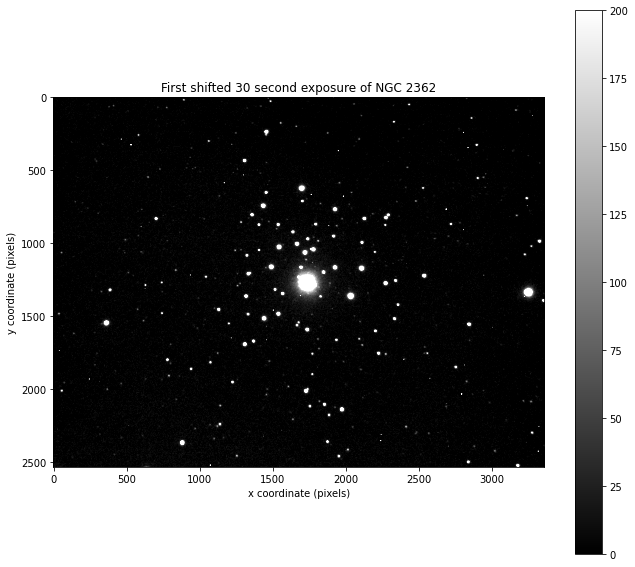

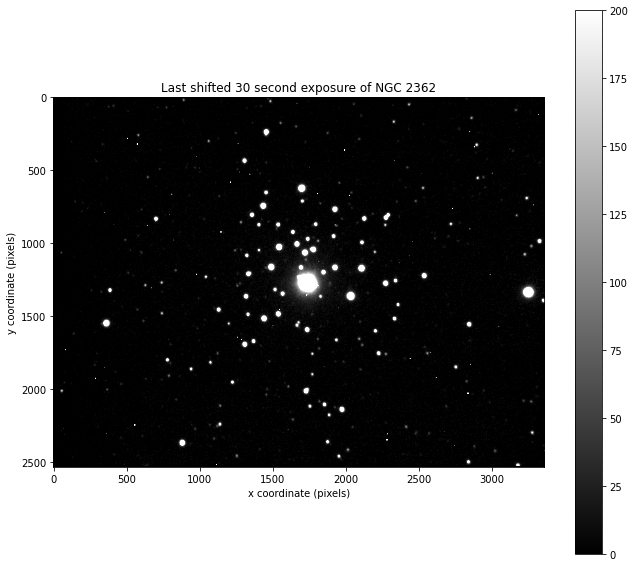

In [107]:
first_shifted = CCDData.read("sproc_NGC_2362_V_30.000secs00009656.fits", unit="adu")
fig, ax = plt.subplots(figsize = (11,10))
plt.imshow(first_shifted, cmap='gray', vmin=0, vmax=2*100)
plt.xlabel('x coordinate (pixels)')
plt.ylabel('y coordinate (pixels)')
plt.title('First shifted 30 second exposure of NGC 2362')
plt.colorbar()

last_shifted = CCDData.read("sproc_NGC_2362_V_30.000secs00012508.fits", unit="adu")
fig, ax = plt.subplots(figsize = (11,10))
plt.imshow(last_shifted, cmap='gray',  vmin=0, vmax=200)
plt.xlabel('x coordinate (pixels)')
plt.ylabel('y coordinate (pixels)')
plt.title('Last shifted 30 second exposure of NGC 2362')
plt.colorbar()

<font color='Blue'> **Figure 2**: Two 30 seconds exposures of NGC 2362, with the background subtracted and shifted to compensate for celestial movement. 

>Here I experimented with several vmax and vmin values. Given that we have subtracted the background, I think a vmin of 0 is justifiable.

## Scaling

**Task 14.** Create a collection of shifted images of NGC 2362 (called images) and read these images into scim. 

In [108]:
simages = ccdproc.ImageFileCollection(".",glob_include='sproc_NGC_2362_V_30*')
scim = [CCDData.read(fn, unit = "adu") for fn in images.files_filtered(PICTTYPE = 1)]
print(scim[0])

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.
INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
INFO: using the unit adu passed to the FITS reader inste

**Task 15.** To determine scalings, we haved identified bright stars that are in all the images, and we will use the fluxes of these stars to see how the images have been dimmed (relative to a reference image) by passing clouds and scattering/absorption of light by our atmosphere.

Below we have defined the positions of three stars and defined circular 20 pixel apertures for photometry.

In [109]:
positions = [(1538.0,1488.0), (2269,1279), (1776,1047)]   #x-y notation
apertures = CircularAperture(positions, r=20.0)


>This uses similar code as in lab 1 (if I recall correctly) - defines a set of circular apertures of radius 20 with centres at the array of coordinates defined in positions

**Task 16.** We can measure the counts of the three stars in the first image, and print them to the screen. This is aperture photometry, so it's adding up the flux (above the background) within some radius. Run the following code cell.

In [110]:
phot_table = aperture_photometry(scim[0], apertures)
print(phot_table)

 id xcenter ycenter    aperture_sum    aperture_sum_err
      pix     pix          adu               adu       
--- ------- ------- ------------------ ----------------
  1  1538.0  1488.0 1093289.1865052278              0.0
  2  2269.0  1279.0 1103114.0603960021              0.0
  3  1776.0  1047.0 1401021.4676289875              0.0


>As expected, we see the sum of pixel counts within the apertures. Qualitatively, looking each star in ds9, these aperture sums seem to match up with which stars I observe as brighter.

**Task 17.** Now add aditional bright stars to this list, making sure they do not have bright neighbours and they aren't saturated in the CCD images (i.e. they don't peak at 60,000+ counts per pixel). 

In [111]:
positions = positions + [(2840, 1558), (2202, 1605), (884, 2370), (365, 1552), (1310, 1695)]

#selected a handful of stars


**Task 18.** Perform aperture photometry for the updated star list using the first image.

In [112]:
apertures = CircularAperture(positions, r=20.0)
phot_table = aperture_photometry(scim[0], apertures)
print(phot_table)

#We can copy/reuse the code from tasks 15 and 16

 id xcenter ycenter    aperture_sum    aperture_sum_err
      pix     pix          adu               adu       
--- ------- ------- ------------------ ----------------
  1  1538.0  1488.0 1093289.1865052278              0.0
  2  2269.0  1279.0 1103114.0603960021              0.0
  3  1776.0  1047.0 1401021.4676289875              0.0
  4  2840.0  1558.0  674099.3471441739              0.0
  5  2202.0  1605.0  411804.7410110746              0.0
  6   884.0  2370.0 1595026.2687163858              0.0
  7   365.0  1552.0 2827369.4446683903              0.0
  8  1310.0  1695.0  953854.9585951616              0.0


**Task 19.** Let's now do determine the counts (fluxes) for these stars in all of the images. Don't forget to use comments to describe what the following code is doing (and why it's being done).


In [113]:
phot_table=[]

#we iterate over the science images (scaled) and add to the photon table for the set of apertures for that that image

#the location of the apertures remains constant for each of the images, the photometry output is not
for idx, thisimage in enumerate(scim): 
    phot_table.extend([aperture_photometry(thisimage, apertures)])
    print(idx, phot_table[idx])



0  id xcenter ycenter    aperture_sum    aperture_sum_err
      pix     pix          adu               adu       
--- ------- ------- ------------------ ----------------
  1  1538.0  1488.0 1093289.1865052278              0.0
  2  2269.0  1279.0 1103114.0603960021              0.0
  3  1776.0  1047.0 1401021.4676289875              0.0
  4  2840.0  1558.0  674099.3471441739              0.0
  5  2202.0  1605.0  411804.7410110746              0.0
  6   884.0  2370.0 1595026.2687163858              0.0
  7   365.0  1552.0 2827369.4446683903              0.0
  8  1310.0  1695.0  953854.9585951616              0.0
1  id xcenter ycenter    aperture_sum    aperture_sum_err
      pix     pix          adu               adu       
--- ------- ------- ------------------ ----------------
  1  1538.0  1488.0 1097137.1579342252              0.0
  2  2269.0  1279.0  1115189.435755692              0.0
  3  1776.0  1047.0  1403358.315592039              0.0
  4  2840.0  1558.0  675481.0280367458      

**Task 20.** To print the fluxes (no coordinates) for the stars in the first image (index=0), we can use the following command.

In [114]:
print(phot_table[0]['aperture_sum'])

[1093289.18650523 1103114.060396   1401021.46762899  674099.34714417
  411804.74101107 1595026.26871639 2827369.44466839  953854.95859516] adu


>This just accesses a keyword that's defined as part of the underlying data structure that holds the data. The print command just calls the ```__str__``` function, which is a projection of this underlying data formatted into a string - but it's not the structure of the data itself.

**Task 21.** We are going use the 7th image (index 6) as our reference image for the combine. What properties would we like a reference image to have (e.g. signal-to-noise, observing conditions)?

>We'd want this reference image to have a low signal to noise, and to be qualitatively the observation that has been taken under the best set of observing conditions.

**Task 22.** What is the following series of commands doing? 

In [115]:
#This iterates over the photon tables, prints the index of that image, then prints the quotient of the fluxes of the stars in the reference image and that science image.

#The last line calculates median of the fluxes of the stars in the reference image and compares that with the science image
for idx, thisimage in enumerate(scim): 
    print(idx)
    print(phot_table[6]['aperture_sum']/phot_table[idx]['aperture_sum'])
    print(np.ma.median(phot_table[6]['aperture_sum']/phot_table[idx]['aperture_sum']))

0
[0.12580233 0.12621158 0.09870077 0.18905988 0.30612792 0.08250494
 0.04722938 0.23190355]
0.12600695689350322
1
[0.1253611  0.12484495 0.09853642 0.18867317 0.30578421 0.08236916
 0.04705128 0.23209416]
0.12510302924272435
2
[0.12526849 0.12480355 0.09855591 0.18861851 0.30549034 0.08220562
 0.0468598  0.23307869]
0.1250360190618327
3
[0.99077837 0.99664249 1.00345542 0.9952654  1.00718285 0.98061416
 0.99890486 0.99670585]
0.9966741705012105
4
[0.99695159 0.97534262 0.99306227 1.00424131 0.98755572 0.97317655
 0.99704026 0.98950788]
0.9912850738555052
5
[1.00444806 1.00188901 0.99663267 0.99324257 1.00027227 0.99903713
 1.00091676 0.99908815]
0.9996802091840281
6
[1. 1. 1. 1. 1. 1. 1. 1.]
1.0
7
[0.97904826 1.00589309 0.98464075 0.99185811 0.98353909 0.98701057
 0.9932685  1.00170518]
0.9894343399941012
8
[0.99044093 0.98283121 0.9884495  0.9899091  0.97113181 0.96985344
 0.97675053 0.974927  ]
0.9797908704998854
9
[0.98334779 0.99264819 0.99671324 0.98708065 0.9729426  0.97312488
 

# Combine

**Task 23.**  Happy with the scalings? How have you confirmed that they make sense (and is this documented here)? If you are happy with the scalings then let's combine the images together using two methods - averaging and median combine. Comment on the following code cell; what does minmax clip do?

>The scalings make sense - they're all values that are not too far off 1. The first three images have a very low ratio, which means there's more light in the first three images, something that holds up when inspecting ds9.

In [116]:
images = ccdproc.ImageFileCollection(".",glob_include = 'sproc_NGC_2362_V_30*')
scim = [CCDData.read(fn) for fn in images.files_filtered()]
#this loop iterates over the science images and calculates (and prints) the ratio of the medians as above. 
#but here, we apply the scalings from the aperture photometry to the entire image.
for idx, thisimage in enumerate(scim): 
    m = np.ma.median(phot_table[6]['aperture_sum'] / phot_table[idx]['aperture_sum'])
    print(m)
    scim[idx] = scim[idx].multiply(m * u.adu)

#calculates using ccdproc the average combine
#minmax allows combine to discard any pixels with values below -500 fro the calculation of the average/median
sci_average = ccdproc.combine(scim, method = 'average',dtype = np.float32, 
                              minmax_clip = True, minmax_clip_min = -500)
#writes to file
sci_average.write("NGC_2362_V_average.fits", overwrite=True)

#calculates using the median combine
sci_median = ccdproc.combine(scim, method = 'median',dtype = np.float32, 
                             minmax_clip = True, minmax_clip_min = -500)

#writes to file
sci_median.write("NGC_2362_V_median.fits", overwrite=True)

#removes scim from the namespace and frees up ram
del(scim)
collected = gc.collect()
print('Check garbage collection', collected)

0.12600695689350322
0.12510302924272435
0.1250360190618327
0.9966741705012105
0.9912850738555052
0.9996802091840281
1.0
0.9894343399941012
0.9797908704998854
0.9898644161106533
0.98384913488411
0.9679357074277153
0.9761281876393664
Check garbage collection 5980


**Task 24.**  How do the combined images visually compare?



>Opening the two images in ds9, and setting zscale, a qualitative observation is that the average combine looks more 'smudged', like it has less contrast. On the plus side, it seems to have less variation in the noise in the background, but if this is as a result of outliers being consistenly factored in for each cell, then this is not necessarily a good thing.

**Task 25.** How does the photometry of the final product compare with the reference photometry? How do the statistics compare? Below we provide a sample code to print out the stats for the average stacked image. Perform the similar task for the median stacked image.

In [117]:
print('Average combine')
#this performs photometry on the average
phot_table_average = aperture_photometry(sci_average, apertures)
print('Median pixel value', np.ma.median(sci_average))
#this takes the standard deviation of a blank region of the image without stars
print('Standard deviation', np.std(sci_average[400:500,400:500]))
print(phot_table_average)
#this calculates the ratio of the photon counts for the stars of the reference image to the combine
print(phot_table[6]['aperture_sum']/phot_table_average['aperture_sum'])
#this shows the median ratio
print(np.ma.median(phot_table[6]['aperture_sum']/phot_table_average['aperture_sum']))


#everything here does the same thing, except with the median combine
print('\nMedian combine')
phot_table_median = aperture_photometry(sci_median, apertures)
print('Median pixel value', np.ma.median(sci_median))
print('Standard deviation', np.std(sci_median[400:500,400:500]))
print(phot_table_median)
print(phot_table[6]['aperture_sum']/phot_table_median['aperture_sum'])
print(np.ma.median(phot_table[6]['aperture_sum']/phot_table_median['aperture_sum']))
  

Average combine
Median pixel value -0.4224131107330322
Standard deviation 9.670722007751465
 id xcenter ycenter    aperture_sum     aperture_sum_err 
      pix     pix          adu2               adu2       
--- ------- ------- ------------------ ------------------
  1  1538.0  1488.0  722086.6062289381  5073.409563322826
  2  2269.0  1279.0   755122.203034933   5199.72228017893
  3  1776.0  1047.0  1009092.838443851  7026.387712996104
  4  2840.0  1558.0  353485.6042807478  2324.556926343877
  5  2202.0  1605.0 116236.69990982984  845.8869235771202
  6   884.0  2370.0 1173581.0654825496  7615.394092318069
  7   365.0  1552.0 2316225.6985411383 15968.681186356847
  8  1310.0  1695.0  599494.7003138657  4209.517362009652
[0.19047345 0.18437516 0.13703585 0.36053843 1.08455357 0.11213333
 0.05765195 0.36898133] 1 / adu
0.18742430206102983 1 / adu

Median combine
Median pixel value -0.21078841388225555
Standard deviation 7.59330940246582
 id xcenter ycenter    aperture_sum     aperture_su

>These are some interesting results - if we look at the standard deviation for the average results in the blank section, it is higher than the standard devation for the median combine even though the median combine visually seems like it is 'grainier' than the average combine. Perhaps this is because the median pixel value is closer to 0.

>Aperture sums in the median combine tend to be higher than the average combine - this is not what I expected as I would think that the median combine is more likely to discard 'borderline' pixels on the fringes of bright objects. Perhaps this is because the apertures are set at a constant size that is quite large, and the lower median pixel value means that the empty space around the star within the aperture decreases the total count within the aperture.

**Task 26.** An alternative to the median and average combine is an average with min-max rejection, which rejects the n-highest and n-lowest pixel values before doing an average combine. Combine the images using this method and then visuall inspect them.

In [118]:
images = ccdproc.ImageFileCollection(".", glob_include = 'sproc_NGC_2362_V_30*')
scim = [CCDData.read(fn) for fn in images.files_filtered()]
#import

#scales and normalises w.r.t. reference image
for idx, thisimage in enumerate(scim): 
    m = np.ma.median(phot_table[6]['aperture_sum']/phot_table[idx]['aperture_sum'])
    print(m)
    scim[idx] = scim[idx].multiply(m * u.adu)

#combine with average, but now pass an additional clip_extrema argument in order to discard the three highest and three lowest values.
sci_minmax = ccdproc.combine(scim, method = 'average', dtype = np.float32, 
                             minmax_clip = True,minmax_clip_min = -500, clip_extrema = (3,3))
sci_minmax.write("NGC_2362_V_minmax.fits", overwrite = True)


0.12600695689350322
0.12510302924272435
0.1250360190618327
0.9966741705012105
0.9912850738555052
0.9996802091840281
1.0
0.9894343399941012
0.9797908704998854
0.9898644161106533
0.98384913488411
0.9679357074277153
0.9761281876393664


>Inspecting these with ds9, qualitatively I can't really tell a difference compared to the average combine image.

**Task 27.**  Adapt the code from above to determine the statistics for the average combine with min-max rejection. How do the statistics for this combined image compare with the average and median compbined images? 


In [119]:
#everything here does the same thing, except with the minmax combine
print('\nMinmax combine')
phot_table_minmax = aperture_photometry(sci_minmax, apertures)
print('Median pixel value', np.ma.median(sci_minmax))
print('Standard deviation', np.std(sci_minmax[400:500,400:500]))
print(phot_table_minmax)
print(phot_table[6]['aperture_sum']/phot_table_minmax['aperture_sum'])
print(np.ma.median(phot_table[6]['aperture_sum']/phot_table_minmax['aperture_sum']))



Minmax combine
Median pixel value -0.47893697023391724
Standard deviation 9.33417797088623
 id xcenter ycenter    aperture_sum     aperture_sum_err 
      pix     pix          adu2               adu2       
--- ------- ------- ------------------ ------------------
  1  1538.0  1488.0  744655.1709900998  4910.120821662672
  2  2269.0  1279.0  779805.6614831664  5055.689936294563
  3  1776.0  1047.0 1039913.7182651118  6789.462007314908
  4  2840.0  1558.0  363250.0139530136 2246.5503845635376
  5  2202.0  1605.0  117851.9976856035  801.2508793840707
  6   884.0  2370.0 1213148.9879745774  7382.002013917798
  7   365.0  1552.0  2388401.286603115 15373.645875002618
  8  1310.0  1695.0  617372.2103126531  4060.750321704871
[0.18470069 0.17853906 0.1329744  0.35084691 1.06968851 0.108476
 0.05590975 0.35829658] 1 / adu
0.18161987892685957 1 / adu


>Here, the median pixel is the lowest out of all of them - this does not surprise me as throughout the process of discarding the three highest values and three lowest values, we're far more likely to get an outlier be an uncharacteristically saturated pixel than an uncharacteristed dark pixel. If those are being discarded, then it makes sense our median is lower.

>The standard deviation is about the same as the average combine, which to me is unexpected - one would expect it to tighten the standard deviation up. Nevertheless, note that the standard deviation is calculated 'horizontally' across the pixels in the combine, so if there's a larger scale structural effect, at the end of the day we're still calculating the mean.

>Most of these values match the average combine.

**Task 28.** Don't forget to write your key **conclusions** in this notebook.

>This lab went through the process of shifting images with systemic translations due to celestial movement by tracking the movement of the centroid of a known object (or at least an object that's not expected to vary in characteristics over the timescale of the observations).

>Then, the images were scaled using the photometry of reference stars, and combined using three separate statistical methods to yield a combined science image with low signal to noise.